## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [13]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [14]:
train, test = keras.datasets.cifar10.load_data()

In [15]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [16]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [31]:
from keras.regularizers import l1_l2
from keras.layers import Activation, Dropout, BatchNormalization


def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], 
            pre_activate=False, drp_ratio=0.2, l1_ratio=0.0, l2_ratio=0.0):
    
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   name='hidden_layer'+str(i+1),
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(input_layer)
            x = Dropout(drp_ratio)(x)
            
            if pre_activate:
                x = BatchNormalization()(x)
                x = Activation('relu')(x)
            else:
                x = Activation('relu')(x)
                x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   name='hidden_layer'+str(i+1),
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(x)
            x = Dropout(drp_ratio)(x)
            
            if pre_activate:
                x = BatchNormalization()(x)
                x = Activation('relu')(x)
            else:
                x = Activation('relu')(x)
                x = BatchNormalization()(x)

    out = keras.layers.Dense(units=output_units, activation='softmax', name='output')(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [35]:
"""Code Here
設定超參數
"""
Learning_rate = 1e-3
Epochs = 10
Batch_size = [32, 128, 256]
Pre_activate = [True, False]
L1_EXP = [1e-2, 1e-8, 0.0]
L2_EXP = [1e-2, 1e-8, 0.0]
drp_ratio_exp = [0.1, 0.2, 0.4]

Momentum = 0.95

In [36]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for i, (bs, pre, l1, l2, drp) in enumerate(product(Batch_size, Pre_activate, L1_EXP, L2_EXP, drp_ratio_exp)):
    model = build_mlp(input_shape=x_train.shape[1:], drp_ratio=drp, 
                      pre_activate=pre, l1_ratio=l1, l2_ratio=l2)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=Learning_rate, nesterov=True, momentum=Momentum)
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
    
    model.fit(x_train, y_train, 
              epochs=Epochs, 
              batch_size=bs, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-bs-%s-pre-%s-drp-%s-l1-%s-l2-%s" % (str(bs), str(pre), str(drp), str(l1), str(l2))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}
    

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_33 (Dropout)         (None, 512)               0         
_________________________________________________________________
batch_normalization_33 (Batc (None, 512)               2048      
_________________________________________________________________
activation_33 (Activation)   (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_34 (Dropout)         (None, 256)               0   

Epoch 1/10
1563/1563 [==============================] - 20s 13ms/step - loss: 33.1526 - accuracy: 0.1767 - val_loss: 7.0444 - val_accuracy: 0.1772
Epoch 2/10
1563/1563 [==============================] - 20s 13ms/step - loss: 6.1434 - accuracy: 0.1949 - val_loss: 5.9585 - val_accuracy: 0.1368
Epoch 3/10
1563/1563 [==============================] - 20s 13ms/step - loss: 5.2350 - accuracy: 0.1991 - val_loss: 5.0672 - val_accuracy: 0.1929
Epoch 4/10
1563/1563 [==============================] - 20s 13ms/step - loss: 4.8199 - accuracy: 0.1995 - val_loss: 4.8758 - val_accuracy: 0.1336
Epoch 5/10
1563/1563 [==============================] - 21s 13ms/step - loss: 4.6511 - accuracy: 0.1922 - val_loss: 4.6459 - val_accuracy: 0.1698
Epoch 6/10
1563/1563 [==============================] - 22s 14ms/step - loss: 4.5950 - accuracy: 0.1927 - val_loss: 4.6417 - val_accuracy: 0.1651
Epoch 7/10
1563/1563 [==============================] - 20s 13ms/step - loss: 4.5438 - accuracy: 0.1936 - val_loss: 4.7091 

Epoch 7/10
1563/1563 [==============================] - 22s 14ms/step - loss: 3.9334 - accuracy: 0.2286 - val_loss: 4.2876 - val_accuracy: 0.1379
Epoch 8/10
1563/1563 [==============================] - 20s 13ms/step - loss: 3.8587 - accuracy: 0.2310 - val_loss: 3.8469 - val_accuracy: 0.1741
Epoch 9/10
1563/1563 [==============================] - 24s 15ms/step - loss: 3.8629 - accuracy: 0.2283 - val_loss: 3.9199 - val_accuracy: 0.1794
Epoch 10/10
1563/1563 [==============================] - 23s 15ms/step - loss: 3.8700 - accuracy: 0.2327 - val_loss: 4.2584 - val_accuracy: 0.1283
Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
d

Epoch 1/10
1563/1563 [==============================] - 15s 9ms/step - loss: 33.5656 - accuracy: 0.2133 - val_loss: 7.4510 - val_accuracy: 0.1182
Epoch 2/10
1563/1563 [==============================] - 14s 9ms/step - loss: 5.3215 - accuracy: 0.2259 - val_loss: 4.9253 - val_accuracy: 0.1411
Epoch 3/10
1563/1563 [==============================] - 15s 9ms/step - loss: 4.3121 - accuracy: 0.2310 - val_loss: 4.3359 - val_accuracy: 0.1514
Epoch 4/10
1563/1563 [==============================] - 15s 9ms/step - loss: 4.0689 - accuracy: 0.2305 - val_loss: 5.3309 - val_accuracy: 0.1090
Epoch 5/10
1563/1563 [==============================] - 18s 12ms/step - loss: 3.9951 - accuracy: 0.2309 - val_loss: 4.3945 - val_accuracy: 0.1467
Epoch 6/10
1563/1563 [==============================] - 18s 11ms/step - loss: 3.9411 - accuracy: 0.2291 - val_loss: 4.8717 - val_accuracy: 0.1339
Epoch 7/10
1563/1563 [==============================] - 16s 10ms/step - loss: 3.9116 - accuracy: 0.2296 - val_loss: 4.1670 - va

Epoch 7/10
1563/1563 [==============================] - 22s 14ms/step - loss: 1.7619 - accuracy: 0.4625 - val_loss: 1.9142 - val_accuracy: 0.3975
Epoch 8/10
1563/1563 [==============================] - 24s 15ms/step - loss: 1.7579 - accuracy: 0.4649 - val_loss: 1.8990 - val_accuracy: 0.4100
Epoch 9/10
1563/1563 [==============================] - 23s 15ms/step - loss: 1.7510 - accuracy: 0.4691 - val_loss: 1.9842 - val_accuracy: 0.3679
Epoch 10/10
1563/1563 [==============================] - 25s 16ms/step - loss: 1.7515 - accuracy: 0.4682 - val_loss: 2.2524 - val_accuracy: 0.3105
Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
d

Epoch 1/10
1563/1563 [==============================] - 23s 15ms/step - loss: 1.7811 - accuracy: 0.3609 - val_loss: 1.7535 - val_accuracy: 0.3787
Epoch 2/10
1563/1563 [==============================] - 26s 17ms/step - loss: 1.5672 - accuracy: 0.4405 - val_loss: 1.5189 - val_accuracy: 0.4635
Epoch 3/10
1563/1563 [==============================] - 24s 16ms/step - loss: 1.4895 - accuracy: 0.4670 - val_loss: 1.4442 - val_accuracy: 0.4842
Epoch 4/10
1563/1563 [==============================] - 24s 16ms/step - loss: 1.4259 - accuracy: 0.4911 - val_loss: 1.4143 - val_accuracy: 0.4989
Epoch 5/10
1563/1563 [==============================] - 26s 16ms/step - loss: 1.3800 - accuracy: 0.5093 - val_loss: 1.4178 - val_accuracy: 0.4922
Epoch 6/10
1563/1563 [==============================] - 23s 15ms/step - loss: 1.3456 - accuracy: 0.5201 - val_loss: 1.3420 - val_accuracy: 0.5266
Epoch 7/10
1563/1563 [==============================] - 21s 14ms/step - loss: 1.3096 - accuracy: 0.5339 - val_loss: 1.4247 -

Epoch 7/10
1563/1563 [==============================] - 25s 16ms/step - loss: 1.6568 - accuracy: 0.4063 - val_loss: 1.5727 - val_accuracy: 0.4369
Epoch 8/10
1563/1563 [==============================] - 24s 16ms/step - loss: 1.6356 - accuracy: 0.4140 - val_loss: 1.5390 - val_accuracy: 0.4510
Epoch 9/10
1563/1563 [==============================] - 26s 16ms/step - loss: 1.6162 - accuracy: 0.4221 - val_loss: 1.5155 - val_accuracy: 0.4609
Epoch 10/10
1563/1563 [==============================] - 22s 14ms/step - loss: 1.5965 - accuracy: 0.4315 - val_loss: 1.5280 - val_accuracy: 0.4547
Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
d

Epoch 1/10
1563/1563 [==============================] - 17s 11ms/step - loss: 2.0587 - accuracy: 0.2503 - val_loss: 1.8279 - val_accuracy: 0.3280
Epoch 2/10
1563/1563 [==============================] - 17s 11ms/step - loss: 1.8580 - accuracy: 0.3249 - val_loss: 1.7570 - val_accuracy: 0.3591
Epoch 3/10
1563/1563 [==============================] - 16s 10ms/step - loss: 1.7915 - accuracy: 0.3537 - val_loss: 1.6415 - val_accuracy: 0.4031
Epoch 4/10
1563/1563 [==============================] - 16s 10ms/step - loss: 1.7457 - accuracy: 0.3700 - val_loss: 1.6757 - val_accuracy: 0.3974
Epoch 5/10
1563/1563 [==============================] - 16s 10ms/step - loss: 1.7086 - accuracy: 0.3858 - val_loss: 1.5650 - val_accuracy: 0.4374
Epoch 6/10
1563/1563 [==============================] - 16s 10ms/step - loss: 1.6818 - accuracy: 0.3979 - val_loss: 1.5823 - val_accuracy: 0.4279
Epoch 7/10
1563/1563 [==============================] - 16s 10ms/step - loss: 1.6561 - accuracy: 0.4068 - val_loss: 1.5807 -

Epoch 7/10
1563/1563 [==============================] - 22s 14ms/step - loss: 1.8342 - accuracy: 0.4325 - val_loss: 2.0870 - val_accuracy: 0.3304
Epoch 8/10
1563/1563 [==============================] - 24s 15ms/step - loss: 1.8298 - accuracy: 0.4349 - val_loss: 1.8593 - val_accuracy: 0.4177
Epoch 9/10
1563/1563 [==============================] - 20s 13ms/step - loss: 1.8233 - accuracy: 0.4367 - val_loss: 2.1767 - val_accuracy: 0.3335
Epoch 10/10
1563/1563 [==============================] - 20s 13ms/step - loss: 1.8204 - accuracy: 0.4377 - val_loss: 1.8749 - val_accuracy: 0.4171
Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
d

Epoch 1/10
1563/1563 [==============================] - 14s 9ms/step - loss: 1.8870 - accuracy: 0.3225 - val_loss: 1.6592 - val_accuracy: 0.4039
Epoch 2/10
1563/1563 [==============================] - 14s 9ms/step - loss: 1.6683 - accuracy: 0.4052 - val_loss: 1.5694 - val_accuracy: 0.4365
Epoch 3/10
1563/1563 [==============================] - 14s 9ms/step - loss: 1.5936 - accuracy: 0.4320 - val_loss: 1.5122 - val_accuracy: 0.4561
Epoch 4/10
1563/1563 [==============================] - 14s 9ms/step - loss: 1.5377 - accuracy: 0.4506 - val_loss: 1.5564 - val_accuracy: 0.4350
Epoch 5/10
1563/1563 [==============================] - 14s 9ms/step - loss: 1.5027 - accuracy: 0.4625 - val_loss: 1.4656 - val_accuracy: 0.4807
Epoch 6/10
1563/1563 [==============================] - 14s 9ms/step - loss: 1.4628 - accuracy: 0.4816 - val_loss: 1.4895 - val_accuracy: 0.4731
Epoch 7/10
1563/1563 [==============================] - 14s 9ms/step - loss: 1.4363 - accuracy: 0.4887 - val_loss: 1.4673 - val_ac

1563/1563 [==============================] - 10s 7ms/step - loss: 1.3098 - accuracy: 0.5352 - val_loss: 1.3526 - val_accuracy: 0.5215
Epoch 8/10
1563/1563 [==============================] - 11s 7ms/step - loss: 1.2783 - accuracy: 0.5454 - val_loss: 1.3580 - val_accuracy: 0.5133
Epoch 9/10
1563/1563 [==============================] - 11s 7ms/step - loss: 1.2457 - accuracy: 0.5566 - val_loss: 1.7026 - val_accuracy: 0.4352
Epoch 10/10
1563/1563 [==============================] - 10s 7ms/step - loss: 1.2212 - accuracy: 0.5660 - val_loss: 1.4775 - val_accuracy: 0.4868
Model: "model_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_108 (Dro

Epoch 1/10
1563/1563 [==============================] - 20s 13ms/step - loss: 31.7890 - accuracy: 0.2134 - val_loss: 4.1536 - val_accuracy: 0.1736
Epoch 2/10
1563/1563 [==============================] - 21s 14ms/step - loss: 3.1475 - accuracy: 0.2185 - val_loss: 4.4377 - val_accuracy: 0.1346
Epoch 3/10
1563/1563 [==============================] - 22s 14ms/step - loss: 2.7784 - accuracy: 0.2144 - val_loss: 2.5754 - val_accuracy: 0.1973
Epoch 4/10
1563/1563 [==============================] - 22s 14ms/step - loss: 2.7902 - accuracy: 0.2081 - val_loss: 2.9557 - val_accuracy: 0.1691
Epoch 5/10
1563/1563 [==============================] - 22s 14ms/step - loss: 2.7311 - accuracy: 0.1975 - val_loss: 2.7594 - val_accuracy: 0.1385
Epoch 6/10
1563/1563 [==============================] - 23s 15ms/step - loss: 2.4933 - accuracy: 0.1838 - val_loss: 3.3256 - val_accuracy: 0.1185
Epoch 7/10
1563/1563 [==============================] - 23s 14ms/step - loss: 2.4686 - accuracy: 0.1785 - val_loss: 2.5931 

Epoch 7/10
1563/1563 [==============================] - 20s 13ms/step - loss: 2.4620 - accuracy: 0.0974 - val_loss: 2.4617 - val_accuracy: 0.1000
Epoch 8/10
1563/1563 [==============================] - 20s 13ms/step - loss: 2.4618 - accuracy: 0.0979 - val_loss: 2.4616 - val_accuracy: 0.1000
Epoch 9/10
1563/1563 [==============================] - 21s 13ms/step - loss: 2.4616 - accuracy: 0.0984 - val_loss: 2.4614 - val_accuracy: 0.1000
Epoch 10/10
1563/1563 [==============================] - 21s 13ms/step - loss: 2.4615 - accuracy: 0.0962 - val_loss: 2.4613 - val_accuracy: 0.1000
Model: "model_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_42 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
d

Epoch 1/10
1563/1563 [==============================] - 22s 14ms/step - loss: 34.3464 - accuracy: 0.1631 - val_loss: 4.1133 - val_accuracy: 0.1887
Epoch 2/10
1563/1563 [==============================] - 22s 14ms/step - loss: 3.3989 - accuracy: 0.1569 - val_loss: 2.9446 - val_accuracy: 0.1316
Epoch 3/10
1563/1563 [==============================] - 23s 15ms/step - loss: 2.9203 - accuracy: 0.1431 - val_loss: 3.5800 - val_accuracy: 0.1361
Epoch 4/10
1563/1563 [==============================] - 22s 14ms/step - loss: 2.5502 - accuracy: 0.1093 - val_loss: 2.4632 - val_accuracy: 0.1000
Epoch 5/10
1563/1563 [==============================] - 21s 13ms/step - loss: 2.4631 - accuracy: 0.0978 - val_loss: 2.4629 - val_accuracy: 0.1000
Epoch 6/10
1563/1563 [==============================] - 22s 14ms/step - loss: 2.4630 - accuracy: 0.0994 - val_loss: 2.4628 - val_accuracy: 0.1000
Epoch 7/10
1563/1563 [==============================] - 22s 14ms/step - loss: 2.4631 - accuracy: 0.0984 - val_loss: 2.4630 

1563/1563 [==============================] - 17s 11ms/step - loss: 2.7375 - accuracy: 0.1477 - val_loss: 2.5867 - val_accuracy: 0.1117
Epoch 7/10
1563/1563 [==============================] - 19s 12ms/step - loss: 2.4963 - accuracy: 0.1572 - val_loss: 2.4444 - val_accuracy: 0.1856
Epoch 8/10
1563/1563 [==============================] - 17s 11ms/step - loss: 2.5286 - accuracy: 0.1417 - val_loss: 2.5597 - val_accuracy: 0.1089
Epoch 9/10
1563/1563 [==============================] - 17s 11ms/step - loss: 2.6546 - accuracy: 0.1526 - val_loss: 2.5544 - val_accuracy: 0.1039
Epoch 10/10
1563/1563 [==============================] - 15s 10ms/step - loss: 2.4710 - accuracy: 0.1517 - val_loss: 2.4441 - val_accuracy: 0.1642
Model: "model_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_47 (InputLayer)        [(None, 3072)]            0         
________________________________________________________________

Epoch 1/10
1563/1563 [==============================] - 20s 13ms/step - loss: 10.1748 - accuracy: 0.2819 - val_loss: 6.0288 - val_accuracy: 0.3186
Epoch 2/10
1563/1563 [==============================] - 21s 14ms/step - loss: 4.3485 - accuracy: 0.3053 - val_loss: 3.1577 - val_accuracy: 0.3014
Epoch 3/10
1563/1563 [==============================] - 22s 14ms/step - loss: 2.7059 - accuracy: 0.2898 - val_loss: 2.3427 - val_accuracy: 0.2911
Epoch 4/10
1563/1563 [==============================] - 28s 18ms/step - loss: 2.2052 - accuracy: 0.2970 - val_loss: 2.0036 - val_accuracy: 0.3507
Epoch 5/10
1563/1563 [==============================] - 21s 13ms/step - loss: 2.0361 - accuracy: 0.3071 - val_loss: 2.2379 - val_accuracy: 0.2328
Epoch 6/10
1563/1563 [==============================] - 1237s 791ms/step - loss: 2.0034 - accuracy: 0.2982 - val_loss: 2.0391 - val_accuracy: 0.2712
Epoch 7/10
1563/1563 [==============================] - 21s 14ms/step - loss: 1.9948 - accuracy: 0.2934 - val_loss: 1.91

Epoch 7/10
1563/1563 [==============================] - 22s 14ms/step - loss: 1.6660 - accuracy: 0.4033 - val_loss: 1.6053 - val_accuracy: 0.4237
Epoch 8/10
1563/1563 [==============================] - 23s 15ms/step - loss: 1.6458 - accuracy: 0.4104 - val_loss: 1.5606 - val_accuracy: 0.4452
Epoch 9/10
1563/1563 [==============================] - 22s 14ms/step - loss: 1.6504 - accuracy: 0.4069 - val_loss: 1.5933 - val_accuracy: 0.4247
Epoch 10/10
1563/1563 [==============================] - 25s 16ms/step - loss: 1.6264 - accuracy: 0.4131 - val_loss: 1.5307 - val_accuracy: 0.4490
Model: "model_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_52 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
d

Epoch 1/10
1563/1563 [==============================] - 16s 10ms/step - loss: 1.9158 - accuracy: 0.3201 - val_loss: 1.6683 - val_accuracy: 0.3999
Epoch 2/10
1563/1563 [==============================] - 16s 10ms/step - loss: 1.7339 - accuracy: 0.3769 - val_loss: 1.6693 - val_accuracy: 0.4080
Epoch 3/10
1563/1563 [==============================] - 17s 11ms/step - loss: 1.7164 - accuracy: 0.3831 - val_loss: 1.6472 - val_accuracy: 0.4066
Epoch 4/10
1563/1563 [==============================] - 16s 10ms/step - loss: 1.7135 - accuracy: 0.3832 - val_loss: 1.6713 - val_accuracy: 0.3974
Epoch 5/10
1563/1563 [==============================] - 16s 10ms/step - loss: 1.7092 - accuracy: 0.3843 - val_loss: 1.7636 - val_accuracy: 0.3650
Epoch 6/10
1563/1563 [==============================] - 15s 10ms/step - loss: 1.7159 - accuracy: 0.3815 - val_loss: 1.6047 - val_accuracy: 0.4214
Epoch 7/10
1563/1563 [==============================] - 15s 10ms/step - loss: 1.6832 - accuracy: 0.3929 - val_loss: 1.5972 -

Epoch 7/10
1563/1563 [==============================] - 15s 9ms/step - loss: 1.9814 - accuracy: 0.2673 - val_loss: 1.8693 - val_accuracy: 0.3383
Epoch 8/10
1563/1563 [==============================] - 15s 9ms/step - loss: 1.9858 - accuracy: 0.2685 - val_loss: 1.8548 - val_accuracy: 0.3353
Epoch 9/10
1563/1563 [==============================] - 15s 10ms/step - loss: 1.9673 - accuracy: 0.2714 - val_loss: 1.8586 - val_accuracy: 0.3383
Epoch 10/10
1563/1563 [==============================] - 16s 10ms/step - loss: 1.9516 - accuracy: 0.2795 - val_loss: 1.8786 - val_accuracy: 0.3193
Model: "model_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_57 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dro

Epoch 1/10
1563/1563 [==============================] - 17s 11ms/step - loss: 10.3375 - accuracy: 0.2198 - val_loss: 6.0864 - val_accuracy: 0.2996
Epoch 2/10
1563/1563 [==============================] - 17s 11ms/step - loss: 4.4384 - accuracy: 0.2511 - val_loss: 3.4046 - val_accuracy: 0.2171
Epoch 3/10
1563/1563 [==============================] - 15s 10ms/step - loss: 2.8160 - accuracy: 0.2304 - val_loss: 2.4192 - val_accuracy: 0.2908
Epoch 4/10
1563/1563 [==============================] - 14s 9ms/step - loss: 2.3275 - accuracy: 0.2324 - val_loss: 2.2255 - val_accuracy: 0.2465
Epoch 5/10
1563/1563 [==============================] - 15s 9ms/step - loss: 2.1753 - accuracy: 0.2252 - val_loss: 2.1406 - val_accuracy: 0.1970
Epoch 6/10
1563/1563 [==============================] - 15s 9ms/step - loss: 2.1615 - accuracy: 0.2132 - val_loss: 2.2372 - val_accuracy: 0.1956
Epoch 7/10
1563/1563 [==============================] - 15s 10ms/step - loss: 2.1389 - accuracy: 0.2145 - val_loss: 2.1590 - v

Epoch 7/10
1563/1563 [==============================] - 15s 9ms/step - loss: 1.8335 - accuracy: 0.3344 - val_loss: 1.7268 - val_accuracy: 0.3871
Epoch 8/10
1563/1563 [==============================] - 15s 9ms/step - loss: 1.8281 - accuracy: 0.3353 - val_loss: 1.7089 - val_accuracy: 0.3999
Epoch 9/10
1563/1563 [==============================] - 15s 9ms/step - loss: 1.7921 - accuracy: 0.3509 - val_loss: 1.6423 - val_accuracy: 0.4083
Epoch 10/10
1563/1563 [==============================] - 15s 9ms/step - loss: 1.7797 - accuracy: 0.3588 - val_loss: 1.6419 - val_accuracy: 0.4168
Model: "model_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_62 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropo

Epoch 1/10
1563/1563 [==============================] - 12s 8ms/step - loss: 2.0182 - accuracy: 0.2835 - val_loss: 1.7446 - val_accuracy: 0.3740
Epoch 2/10
1563/1563 [==============================] - 12s 7ms/step - loss: 1.8388 - accuracy: 0.3328 - val_loss: 1.7266 - val_accuracy: 0.3850
Epoch 3/10
1563/1563 [==============================] - 11s 7ms/step - loss: 1.8550 - accuracy: 0.3256 - val_loss: 1.7649 - val_accuracy: 0.3628
Epoch 4/10
1563/1563 [==============================] - 11s 7ms/step - loss: 1.8410 - accuracy: 0.3342 - val_loss: 1.7317 - val_accuracy: 0.3779
Epoch 5/10
1563/1563 [==============================] - 11s 7ms/step - loss: 1.8434 - accuracy: 0.3337 - val_loss: 1.7796 - val_accuracy: 0.3499
Epoch 6/10
1563/1563 [==============================] - 11s 7ms/step - loss: 1.8637 - accuracy: 0.3243 - val_loss: 1.7575 - val_accuracy: 0.3640
Epoch 7/10
1563/1563 [==============================] - 11s 7ms/step - loss: 1.8506 - accuracy: 0.3313 - val_loss: 1.8245 - val_ac

391/391 [==============================] - 9s 24ms/step - loss: 2.9676 - accuracy: 0.3045 - val_loss: 3.1576 - val_accuracy: 0.2327
Epoch 8/10
391/391 [==============================] - 9s 24ms/step - loss: 2.8872 - accuracy: 0.3007 - val_loss: 3.1300 - val_accuracy: 0.2250
Epoch 9/10
391/391 [==============================] - 10s 25ms/step - loss: 2.8482 - accuracy: 0.3021 - val_loss: 3.3041 - val_accuracy: 0.2030
Epoch 10/10
391/391 [==============================] - 10s 25ms/step - loss: 2.8238 - accuracy: 0.3030 - val_loss: 3.5556 - val_accuracy: 0.1670
Model: "model_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_67 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_198 (Dropout) 

Epoch 1/10
391/391 [==============================] - 8s 21ms/step - loss: 110.4060 - accuracy: 0.2894 - val_loss: 10.8402 - val_accuracy: 0.1002
Epoch 2/10
391/391 [==============================] - 8s 22ms/step - loss: 5.3046 - accuracy: 0.2914 - val_loss: 3.9193 - val_accuracy: 0.1815
Epoch 3/10
391/391 [==============================] - 9s 22ms/step - loss: 3.4651 - accuracy: 0.2977 - val_loss: 3.7282 - val_accuracy: 0.1972
Epoch 4/10
391/391 [==============================] - 9s 22ms/step - loss: 3.2318 - accuracy: 0.2989 - val_loss: 3.9215 - val_accuracy: 0.1348
Epoch 5/10
391/391 [==============================] - 9s 22ms/step - loss: 3.1269 - accuracy: 0.3023 - val_loss: 3.6450 - val_accuracy: 0.1349
Epoch 6/10
391/391 [==============================] - 9s 23ms/step - loss: 3.0533 - accuracy: 0.3031 - val_loss: 3.2304 - val_accuracy: 0.2138
Epoch 7/10
391/391 [==============================] - 9s 22ms/step - loss: 2.9676 - accuracy: 0.3050 - val_loss: 3.5684 - val_accuracy: 0.1

391/391 [==============================] - 10s 25ms/step - loss: 3.8269 - accuracy: 0.2265 - val_loss: 3.8908 - val_accuracy: 0.1976
Epoch 8/10
391/391 [==============================] - 9s 23ms/step - loss: 3.7081 - accuracy: 0.2259 - val_loss: 3.6667 - val_accuracy: 0.2169
Epoch 9/10
391/391 [==============================] - 9s 24ms/step - loss: 3.5367 - accuracy: 0.2293 - val_loss: 3.6011 - val_accuracy: 0.1409
Epoch 10/10
391/391 [==============================] - 10s 24ms/step - loss: 3.5016 - accuracy: 0.2264 - val_loss: 3.5650 - val_accuracy: 0.2041
Model: "model_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_72 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_213 (Dropout) 

Epoch 1/10
391/391 [==============================] - 8s 20ms/step - loss: 110.4536 - accuracy: 0.1866 - val_loss: 10.0938 - val_accuracy: 0.1000
Epoch 2/10
391/391 [==============================] - 8s 20ms/step - loss: 6.2180 - accuracy: 0.2161 - val_loss: 5.3467 - val_accuracy: 0.1609
Epoch 3/10
391/391 [==============================] - 8s 21ms/step - loss: 5.0009 - accuracy: 0.2192 - val_loss: 4.9133 - val_accuracy: 0.1832
Epoch 4/10
391/391 [==============================] - 8s 21ms/step - loss: 4.6213 - accuracy: 0.2262 - val_loss: 4.4507 - val_accuracy: 0.2380
Epoch 5/10
391/391 [==============================] - 8s 21ms/step - loss: 4.1883 - accuracy: 0.2262 - val_loss: 4.1809 - val_accuracy: 0.1634
Epoch 6/10
391/391 [==============================] - 8s 21ms/step - loss: 3.9609 - accuracy: 0.2295 - val_loss: 4.0538 - val_accuracy: 0.1994
Epoch 7/10
391/391 [==============================] - 8s 21ms/step - loss: 3.8274 - accuracy: 0.2275 - val_loss: 3.8065 - val_accuracy: 0.2

391/391 [==============================] - 9s 24ms/step - loss: 3.3538 - accuracy: 0.4891 - val_loss: 3.1903 - val_accuracy: 0.4537
Epoch 8/10
391/391 [==============================] - 9s 24ms/step - loss: 2.8524 - accuracy: 0.4978 - val_loss: 2.9189 - val_accuracy: 0.4011
Epoch 9/10
391/391 [==============================] - 9s 24ms/step - loss: 2.4853 - accuracy: 0.5027 - val_loss: 2.5106 - val_accuracy: 0.4356
Epoch 10/10
391/391 [==============================] - 10s 25ms/step - loss: 2.2187 - accuracy: 0.5106 - val_loss: 2.4398 - val_accuracy: 0.3949
Model: "model_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_77 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_228 (Dropout)  

Epoch 1/10
391/391 [==============================] - 9s 22ms/step - loss: 2.0031 - accuracy: 0.2850 - val_loss: 1.7452 - val_accuracy: 0.3797
Epoch 2/10
391/391 [==============================] - 9s 23ms/step - loss: 1.7338 - accuracy: 0.3785 - val_loss: 1.6272 - val_accuracy: 0.4202
Epoch 3/10
391/391 [==============================] - 9s 23ms/step - loss: 1.6370 - accuracy: 0.4172 - val_loss: 1.6002 - val_accuracy: 0.4216
Epoch 4/10
391/391 [==============================] - 9s 24ms/step - loss: 1.5729 - accuracy: 0.4393 - val_loss: 1.5187 - val_accuracy: 0.4557
Epoch 5/10
391/391 [==============================] - 9s 23ms/step - loss: 1.5347 - accuracy: 0.4533 - val_loss: 1.5213 - val_accuracy: 0.4568
Epoch 6/10
391/391 [==============================] - 11s 29ms/step - loss: 1.4945 - accuracy: 0.4682 - val_loss: 1.5356 - val_accuracy: 0.4448
Epoch 7/10
391/391 [==============================] - 10s 26ms/step - loss: 1.4580 - accuracy: 0.4789 - val_loss: 1.4644 - val_accuracy: 0.47

391/391 [==============================] - 8s 21ms/step - loss: 1.3083 - accuracy: 0.5339 - val_loss: 1.4208 - val_accuracy: 0.4944
Epoch 8/10
391/391 [==============================] - 8s 20ms/step - loss: 1.2734 - accuracy: 0.5479 - val_loss: 1.4399 - val_accuracy: 0.4880
Epoch 9/10
391/391 [==============================] - 8s 21ms/step - loss: 1.2445 - accuracy: 0.5568 - val_loss: 1.4437 - val_accuracy: 0.4870
Epoch 10/10
391/391 [==============================] - 8s 21ms/step - loss: 1.2105 - accuracy: 0.5710 - val_loss: 1.4530 - val_accuracy: 0.4890
Model: "model_77"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_82 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_243 (Dropout)   

Epoch 1/10
391/391 [==============================] - 8s 20ms/step - loss: 13.9936 - accuracy: 0.3309 - val_loss: 12.0006 - val_accuracy: 0.4054
Epoch 2/10
391/391 [==============================] - 8s 20ms/step - loss: 10.4609 - accuracy: 0.4284 - val_loss: 9.1379 - val_accuracy: 0.4375
Epoch 3/10
391/391 [==============================] - 8s 20ms/step - loss: 7.9825 - accuracy: 0.4668 - val_loss: 7.1485 - val_accuracy: 0.4154
Epoch 4/10
391/391 [==============================] - 8s 20ms/step - loss: 6.1877 - accuracy: 0.4911 - val_loss: 5.9911 - val_accuracy: 0.3272
Epoch 5/10
391/391 [==============================] - 8s 21ms/step - loss: 4.8889 - accuracy: 0.5086 - val_loss: 4.6460 - val_accuracy: 0.4207
Epoch 6/10
391/391 [==============================] - 8s 21ms/step - loss: 3.9385 - accuracy: 0.5212 - val_loss: 3.8664 - val_accuracy: 0.4113
Epoch 7/10
391/391 [==============================] - 8s 21ms/step - loss: 3.2498 - accuracy: 0.5359 - val_loss: 3.5014 - val_accuracy: 0.3

391/391 [==============================] - 8s 20ms/step - loss: 3.5581 - accuracy: 0.4075 - val_loss: 3.3341 - val_accuracy: 0.3803
Epoch 8/10
391/391 [==============================] - 8s 22ms/step - loss: 3.0483 - accuracy: 0.4161 - val_loss: 2.8062 - val_accuracy: 0.4332
Epoch 9/10
391/391 [==============================] - 9s 23ms/step - loss: 2.6843 - accuracy: 0.4197 - val_loss: 2.5575 - val_accuracy: 0.4184
Epoch 10/10
391/391 [==============================] - 8s 20ms/step - loss: 2.4089 - accuracy: 0.4317 - val_loss: 2.3382 - val_accuracy: 0.4275
Model: "model_82"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_87 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_258 (Dropout)   

Epoch 1/10
391/391 [==============================] - 8s 20ms/step - loss: 2.1784 - accuracy: 0.2144 - val_loss: 1.9257 - val_accuracy: 0.3199
Epoch 2/10
391/391 [==============================] - 8s 20ms/step - loss: 1.9387 - accuracy: 0.2971 - val_loss: 1.8158 - val_accuracy: 0.3463
Epoch 3/10
391/391 [==============================] - 8s 22ms/step - loss: 1.8486 - accuracy: 0.3317 - val_loss: 1.7294 - val_accuracy: 0.3795
Epoch 4/10
391/391 [==============================] - 8s 21ms/step - loss: 1.7910 - accuracy: 0.3547 - val_loss: 1.7161 - val_accuracy: 0.3819
Epoch 5/10
391/391 [==============================] - 9s 22ms/step - loss: 1.7509 - accuracy: 0.3696 - val_loss: 1.6609 - val_accuracy: 0.3986
Epoch 6/10
391/391 [==============================] - 9s 23ms/step - loss: 1.7146 - accuracy: 0.3817 - val_loss: 1.6395 - val_accuracy: 0.4074
Epoch 7/10
391/391 [==============================] - 8s 20ms/step - loss: 1.6938 - accuracy: 0.3923 - val_loss: 1.6227 - val_accuracy: 0.4064

391/391 [==============================] - 7s 18ms/step - loss: 1.4589 - accuracy: 0.4784 - val_loss: 1.4381 - val_accuracy: 0.4899
Epoch 8/10
391/391 [==============================] - 7s 19ms/step - loss: 1.4298 - accuracy: 0.4885 - val_loss: 1.4625 - val_accuracy: 0.4737
Epoch 9/10
391/391 [==============================] - 7s 17ms/step - loss: 1.4020 - accuracy: 0.5003 - val_loss: 1.5268 - val_accuracy: 0.4592
Epoch 10/10
391/391 [==============================] - 7s 17ms/step - loss: 1.3827 - accuracy: 0.5048 - val_loss: 1.4698 - val_accuracy: 0.4729
Model: "model_87"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_92 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_273 (Dropout)   

Epoch 1/10
391/391 [==============================] - 9s 24ms/step - loss: 109.2485 - accuracy: 0.2230 - val_loss: 9.1786 - val_accuracy: 0.1153
Epoch 2/10
391/391 [==============================] - 9s 23ms/step - loss: 4.9710 - accuracy: 0.2261 - val_loss: 3.1973 - val_accuracy: 0.2548
Epoch 3/10
391/391 [==============================] - 10s 24ms/step - loss: 2.8600 - accuracy: 0.2330 - val_loss: 2.6285 - val_accuracy: 0.2377
Epoch 4/10
391/391 [==============================] - 9s 24ms/step - loss: 2.5897 - accuracy: 0.2434 - val_loss: 2.7167 - val_accuracy: 0.1834
Epoch 5/10
391/391 [==============================] - 10s 24ms/step - loss: 2.5252 - accuracy: 0.2331 - val_loss: 2.6615 - val_accuracy: 0.1854
Epoch 6/10
391/391 [==============================] - 9s 24ms/step - loss: 2.4473 - accuracy: 0.2278 - val_loss: 2.4046 - val_accuracy: 0.2147
Epoch 7/10
391/391 [==============================] - 9s 24ms/step - loss: 2.4004 - accuracy: 0.2260 - val_loss: 2.4517 - val_accuracy: 0.

391/391 [==============================] - 10s 25ms/step - loss: 2.3628 - accuracy: 0.2747 - val_loss: 2.2969 - val_accuracy: 0.2879
Epoch 8/10
391/391 [==============================] - 10s 25ms/step - loss: 2.3489 - accuracy: 0.2717 - val_loss: 2.3607 - val_accuracy: 0.2679
Epoch 9/10
391/391 [==============================] - 10s 25ms/step - loss: 2.3714 - accuracy: 0.2681 - val_loss: 3.6863 - val_accuracy: 0.1158
Epoch 10/10
391/391 [==============================] - 10s 25ms/step - loss: 2.3430 - accuracy: 0.2749 - val_loss: 2.3099 - val_accuracy: 0.2844
Model: "model_92"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_97 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_288 (Dropout

Epoch 1/10
391/391 [==============================] - 9s 23ms/step - loss: 110.8569 - accuracy: 0.2577 - val_loss: 11.1337 - val_accuracy: 0.1011
Epoch 2/10
391/391 [==============================] - 9s 23ms/step - loss: 5.2843 - accuracy: 0.2644 - val_loss: 3.3209 - val_accuracy: 0.1556
Epoch 3/10
391/391 [==============================] - 9s 24ms/step - loss: 2.7752 - accuracy: 0.2660 - val_loss: 2.9402 - val_accuracy: 0.2047
Epoch 4/10
391/391 [==============================] - 9s 23ms/step - loss: 2.5037 - accuracy: 0.2703 - val_loss: 2.5417 - val_accuracy: 0.2569
Epoch 5/10
391/391 [==============================] - 10s 25ms/step - loss: 2.4232 - accuracy: 0.2785 - val_loss: 2.4524 - val_accuracy: 0.2154
Epoch 6/10
391/391 [==============================] - 13s 33ms/step - loss: 2.3883 - accuracy: 0.2808 - val_loss: 2.4448 - val_accuracy: 0.2459
Epoch 7/10
391/391 [==============================] - 11s 29ms/step - loss: 2.4408 - accuracy: 0.2518 - val_loss: 2.5364 - val_accuracy: 

391/391 [==============================] - 10s 26ms/step - loss: 2.5435 - accuracy: 0.1654 - val_loss: 2.5682 - val_accuracy: 0.1308
Epoch 8/10
391/391 [==============================] - 10s 26ms/step - loss: 2.4929 - accuracy: 0.1625 - val_loss: 2.5957 - val_accuracy: 0.1429
Epoch 9/10
391/391 [==============================] - 10s 26ms/step - loss: 2.4732 - accuracy: 0.1595 - val_loss: 2.5432 - val_accuracy: 0.1380
Epoch 10/10
391/391 [==============================] - 10s 26ms/step - loss: 2.4623 - accuracy: 0.1601 - val_loss: 2.4490 - val_accuracy: 0.1575
Model: "model_97"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_102 (InputLayer)       [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_303 (Dropout

Epoch 1/10
391/391 [==============================] - 16s 40ms/step - loss: 14.4984 - accuracy: 0.1970 - val_loss: 12.3038 - val_accuracy: 0.2693
Epoch 2/10
391/391 [==============================] - 13s 32ms/step - loss: 10.8752 - accuracy: 0.2758 - val_loss: 9.4576 - val_accuracy: 0.3136
Epoch 3/10
391/391 [==============================] - 13s 34ms/step - loss: 8.3962 - accuracy: 0.3075 - val_loss: 7.3358 - val_accuracy: 0.3428
Epoch 4/10
391/391 [==============================] - 14s 35ms/step - loss: 6.6193 - accuracy: 0.3244 - val_loss: 5.9186 - val_accuracy: 0.3370
Epoch 5/10
391/391 [==============================] - 14s 35ms/step - loss: 5.3449 - accuracy: 0.3242 - val_loss: 4.7241 - val_accuracy: 0.3795
Epoch 6/10
391/391 [==============================] - 13s 34ms/step - loss: 4.4088 - accuracy: 0.3325 - val_loss: 3.9723 - val_accuracy: 0.3606
Epoch 7/10
391/391 [==============================] - 13s 34ms/step - loss: 3.7525 - accuracy: 0.3253 - val_loss: 3.4419 - val_accura

391/391 [==============================] - 15s 39ms/step - loss: 1.6096 - accuracy: 0.4217 - val_loss: 1.5256 - val_accuracy: 0.4529
Epoch 8/10
391/391 [==============================] - 15s 38ms/step - loss: 1.6015 - accuracy: 0.4263 - val_loss: 1.5164 - val_accuracy: 0.4565
Epoch 9/10
391/391 [==============================] - 15s 38ms/step - loss: 1.5943 - accuracy: 0.4287 - val_loss: 1.5352 - val_accuracy: 0.4489
Epoch 10/10
391/391 [==============================] - 16s 42ms/step - loss: 1.5816 - accuracy: 0.4324 - val_loss: 1.5482 - val_accuracy: 0.4446
Model: "model_102"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_107 (InputLayer)       [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_318 (Dropou

Epoch 1/10
391/391 [==============================] - 13s 33ms/step - loss: 2.1543 - accuracy: 0.2641 - val_loss: 1.8097 - val_accuracy: 0.3370
Epoch 2/10
391/391 [==============================] - 14s 35ms/step - loss: 1.8338 - accuracy: 0.3437 - val_loss: 1.6876 - val_accuracy: 0.3879
Epoch 3/10
391/391 [==============================] - 14s 35ms/step - loss: 1.7514 - accuracy: 0.3701 - val_loss: 1.8232 - val_accuracy: 0.3557
Epoch 4/10
391/391 [==============================] - 14s 36ms/step - loss: 1.6871 - accuracy: 0.3945 - val_loss: 1.5752 - val_accuracy: 0.4356
Epoch 5/10
391/391 [==============================] - 14s 36ms/step - loss: 1.6650 - accuracy: 0.4008 - val_loss: 1.6096 - val_accuracy: 0.4190
Epoch 6/10
391/391 [==============================] - 14s 36ms/step - loss: 1.6386 - accuracy: 0.4115 - val_loss: 1.5462 - val_accuracy: 0.4476
Epoch 7/10
391/391 [==============================] - 14s 35ms/step - loss: 1.6087 - accuracy: 0.4231 - val_loss: 1.5688 - val_accuracy:

391/391 [==============================] - 16s 40ms/step - loss: 3.5010 - accuracy: 0.4360 - val_loss: 3.2787 - val_accuracy: 0.4106
Epoch 8/10
391/391 [==============================] - 14s 36ms/step - loss: 3.0146 - accuracy: 0.4331 - val_loss: 2.8498 - val_accuracy: 0.4070
Epoch 9/10
391/391 [==============================] - 18s 45ms/step - loss: 2.6362 - accuracy: 0.4423 - val_loss: 2.5656 - val_accuracy: 0.4064
Epoch 10/10
391/391 [==============================] - 16s 42ms/step - loss: 2.3633 - accuracy: 0.4436 - val_loss: 2.3156 - val_accuracy: 0.4227
Model: "model_107"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_112 (InputLayer)       [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_333 (Dropou

Epoch 1/10
391/391 [==============================] - 12s 30ms/step - loss: 2.0107 - accuracy: 0.3082 - val_loss: 1.6727 - val_accuracy: 0.4056
Epoch 2/10
391/391 [==============================] - 13s 33ms/step - loss: 1.7075 - accuracy: 0.3937 - val_loss: 1.6031 - val_accuracy: 0.4276
Epoch 3/10
391/391 [==============================] - 13s 35ms/step - loss: 1.6323 - accuracy: 0.4182 - val_loss: 1.5702 - val_accuracy: 0.4416
Epoch 4/10
391/391 [==============================] - 14s 35ms/step - loss: 1.5779 - accuracy: 0.4357 - val_loss: 1.5082 - val_accuracy: 0.4626
Epoch 5/10
391/391 [==============================] - 15s 38ms/step - loss: 1.5381 - accuracy: 0.4509 - val_loss: 1.5230 - val_accuracy: 0.4523
Epoch 6/10
391/391 [==============================] - 14s 37ms/step - loss: 1.5120 - accuracy: 0.4617 - val_loss: 1.5274 - val_accuracy: 0.4576
Epoch 7/10
391/391 [==============================] - 19s 48ms/step - loss: 1.4878 - accuracy: 0.4689 - val_loss: 1.4990 - val_accuracy:

391/391 [==============================] - 12s 32ms/step - loss: 1.7648 - accuracy: 0.3656 - val_loss: 1.6645 - val_accuracy: 0.4046
Epoch 8/10
391/391 [==============================] - 12s 31ms/step - loss: 1.7523 - accuracy: 0.3698 - val_loss: 1.6434 - val_accuracy: 0.4222
Epoch 9/10
391/391 [==============================] - 13s 34ms/step - loss: 1.7381 - accuracy: 0.3735 - val_loss: 1.6296 - val_accuracy: 0.4137
Epoch 10/10
391/391 [==============================] - 14s 35ms/step - loss: 1.7426 - accuracy: 0.3752 - val_loss: 1.6238 - val_accuracy: 0.4208
Model: "model_112"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_117 (InputLayer)       [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_348 (Dropou

Epoch 1/10
391/391 [==============================] - 9s 23ms/step - loss: 2.3610 - accuracy: 0.2027 - val_loss: 1.9283 - val_accuracy: 0.3182
Epoch 2/10
391/391 [==============================] - 10s 25ms/step - loss: 2.0139 - accuracy: 0.2686 - val_loss: 1.8379 - val_accuracy: 0.3427
Epoch 3/10
391/391 [==============================] - 10s 24ms/step - loss: 1.9014 - accuracy: 0.3079 - val_loss: 1.7538 - val_accuracy: 0.3635
Epoch 4/10
391/391 [==============================] - 10s 24ms/step - loss: 1.8525 - accuracy: 0.3272 - val_loss: 1.7291 - val_accuracy: 0.3740
Epoch 5/10
391/391 [==============================] - 9s 24ms/step - loss: 1.8138 - accuracy: 0.3410 - val_loss: 1.6893 - val_accuracy: 0.3868
Epoch 6/10
391/391 [==============================] - 10s 25ms/step - loss: 1.7945 - accuracy: 0.3497 - val_loss: 1.6721 - val_accuracy: 0.3949
Epoch 7/10
391/391 [==============================] - 10s 24ms/step - loss: 1.7727 - accuracy: 0.3608 - val_loss: 1.6626 - val_accuracy: 0

196/196 [==============================] - 9s 47ms/step - loss: 2.9338 - accuracy: 0.2993 - val_loss: 3.2367 - val_accuracy: 0.1967
Epoch 8/10
196/196 [==============================] - 10s 50ms/step - loss: 2.9046 - accuracy: 0.3018 - val_loss: 3.1876 - val_accuracy: 0.1940
Epoch 9/10
196/196 [==============================] - 10s 49ms/step - loss: 2.8971 - accuracy: 0.2997 - val_loss: 3.0592 - val_accuracy: 0.2175
Epoch 10/10
196/196 [==============================] - 9s 47ms/step - loss: 2.8633 - accuracy: 0.2977 - val_loss: 3.1286 - val_accuracy: 0.2326
Model: "model_117"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_122 (InputLayer)       [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_363 (Dropout)

Epoch 1/10
196/196 [==============================] - 9s 44ms/step - loss: 198.9180 - accuracy: 0.2655 - val_loss: 42.2867 - val_accuracy: 0.1000
Epoch 2/10
196/196 [==============================] - 9s 46ms/step - loss: 21.0214 - accuracy: 0.2746 - val_loss: 9.8381 - val_accuracy: 0.1001
Epoch 3/10
196/196 [==============================] - 9s 45ms/step - loss: 5.9867 - accuracy: 0.2926 - val_loss: 4.2752 - val_accuracy: 0.1462
Epoch 4/10
196/196 [==============================] - 9s 47ms/step - loss: 3.3373 - accuracy: 0.2966 - val_loss: 3.6254 - val_accuracy: 0.1311
Epoch 5/10
196/196 [==============================] - 11s 57ms/step - loss: 3.0613 - accuracy: 0.2968 - val_loss: 3.4671 - val_accuracy: 0.1945
Epoch 6/10
196/196 [==============================] - 10s 52ms/step - loss: 2.9633 - accuracy: 0.2951 - val_loss: 3.0622 - val_accuracy: 0.2387
Epoch 7/10
196/196 [==============================] - 9s 45ms/step - loss: 2.9223 - accuracy: 0.2939 - val_loss: 3.4906 - val_accuracy: 

196/196 [==============================] - 8s 40ms/step - loss: 2.6211 - accuracy: 0.3402 - val_loss: 3.1017 - val_accuracy: 0.1816
Epoch 8/10
196/196 [==============================] - 8s 40ms/step - loss: 2.6260 - accuracy: 0.3402 - val_loss: 3.2166 - val_accuracy: 0.2027
Epoch 9/10
196/196 [==============================] - 8s 41ms/step - loss: 2.6147 - accuracy: 0.3405 - val_loss: 2.8756 - val_accuracy: 0.2200
Epoch 10/10
196/196 [==============================] - 8s 41ms/step - loss: 2.5982 - accuracy: 0.3423 - val_loss: 2.9165 - val_accuracy: 0.2369
Model: "model_122"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_127 (InputLayer)       [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_378 (Dropout)  

Epoch 1/10
196/196 [==============================] - 7s 34ms/step - loss: 15.0407 - accuracy: 0.2981 - val_loss: 13.8956 - val_accuracy: 0.3597
Epoch 2/10
196/196 [==============================] - 6s 32ms/step - loss: 12.8451 - accuracy: 0.4028 - val_loss: 11.9670 - val_accuracy: 0.4021
Epoch 3/10
196/196 [==============================] - 6s 33ms/step - loss: 11.1063 - accuracy: 0.4442 - val_loss: 10.3926 - val_accuracy: 0.4382
Epoch 4/10
196/196 [==============================] - 7s 37ms/step - loss: 9.6463 - accuracy: 0.4702 - val_loss: 9.1057 - val_accuracy: 0.4372
Epoch 5/10
196/196 [==============================] - 3051s 16s/step - loss: 8.4002 - accuracy: 0.4933 - val_loss: 8.0231 - val_accuracy: 0.4253
Epoch 6/10
196/196 [==============================] - 6s 30ms/step - loss: 7.3435 - accuracy: 0.5086 - val_loss: 7.0287 - val_accuracy: 0.4529
Epoch 7/10
196/196 [==============================] - 16s 80ms/step - loss: 6.4394 - accuracy: 0.5232 - val_loss: 6.4635 - val_accurac

196/196 [==============================] - 6s 32ms/step - loss: 6.8070 - accuracy: 0.3834 - val_loss: 6.4154 - val_accuracy: 0.3860
Epoch 8/10
196/196 [==============================] - 6s 32ms/step - loss: 6.0435 - accuracy: 0.3919 - val_loss: 5.6699 - val_accuracy: 0.4078
Epoch 9/10
196/196 [==============================] - 7s 35ms/step - loss: 5.3881 - accuracy: 0.4030 - val_loss: 5.0935 - val_accuracy: 0.4140
Epoch 10/10
196/196 [==============================] - 7s 33ms/step - loss: 4.8325 - accuracy: 0.4148 - val_loss: 4.5665 - val_accuracy: 0.4150
Model: "model_127"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_132 (InputLayer)       [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_393 (Dropout)  

Epoch 1/10
196/196 [==============================] - 7s 38ms/step - loss: 2.2842 - accuracy: 0.1857 - val_loss: 2.0027 - val_accuracy: 0.2984
Epoch 2/10
196/196 [==============================] - 7s 33ms/step - loss: 2.0273 - accuracy: 0.2672 - val_loss: 1.8738 - val_accuracy: 0.3335
Epoch 3/10
196/196 [==============================] - 6s 33ms/step - loss: 1.9356 - accuracy: 0.3003 - val_loss: 1.7915 - val_accuracy: 0.3703
Epoch 4/10
196/196 [==============================] - 7s 34ms/step - loss: 1.8732 - accuracy: 0.3208 - val_loss: 1.7451 - val_accuracy: 0.3817
Epoch 5/10
196/196 [==============================] - 6s 31ms/step - loss: 1.8296 - accuracy: 0.3400 - val_loss: 1.7025 - val_accuracy: 0.3960
Epoch 6/10
196/196 [==============================] - 6s 32ms/step - loss: 1.7957 - accuracy: 0.3553 - val_loss: 1.6690 - val_accuracy: 0.4027
Epoch 7/10
196/196 [==============================] - 6s 31ms/step - loss: 1.7629 - accuracy: 0.3658 - val_loss: 1.6663 - val_accuracy: 0.4038

196/196 [==============================] - 6s 29ms/step - loss: 1.5377 - accuracy: 0.4521 - val_loss: 1.5186 - val_accuracy: 0.4588
Epoch 8/10
196/196 [==============================] - 6s 28ms/step - loss: 1.5121 - accuracy: 0.4626 - val_loss: 1.5279 - val_accuracy: 0.4548
Epoch 9/10
196/196 [==============================] - 6s 28ms/step - loss: 1.4924 - accuracy: 0.4675 - val_loss: 1.4799 - val_accuracy: 0.4748
Epoch 10/10
196/196 [==============================] - 6s 29ms/step - loss: 1.4637 - accuracy: 0.4779 - val_loss: 1.4803 - val_accuracy: 0.4716
Model: "model_132"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_137 (InputLayer)       [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_408 (Dropout)  

Epoch 1/10
196/196 [==============================] - 6s 29ms/step - loss: 15.1409 - accuracy: 0.2561 - val_loss: 13.9207 - val_accuracy: 0.3463
Epoch 2/10
196/196 [==============================] - 6s 28ms/step - loss: 12.9560 - accuracy: 0.3577 - val_loss: 12.0420 - val_accuracy: 0.3842
Epoch 3/10
196/196 [==============================] - 6s 29ms/step - loss: 11.2305 - accuracy: 0.3948 - val_loss: 10.4810 - val_accuracy: 0.3957
Epoch 4/10
196/196 [==============================] - 6s 29ms/step - loss: 9.7742 - accuracy: 0.4218 - val_loss: 9.1560 - val_accuracy: 0.4207
Epoch 5/10
196/196 [==============================] - 6s 29ms/step - loss: 8.5356 - accuracy: 0.4400 - val_loss: 8.0130 - val_accuracy: 0.4342
Epoch 6/10
196/196 [==============================] - 6s 31ms/step - loss: 7.4817 - accuracy: 0.4565 - val_loss: 7.0488 - val_accuracy: 0.4491
Epoch 7/10
196/196 [==============================] - 6s 29ms/step - loss: 6.5787 - accuracy: 0.4723 - val_loss: 6.2155 - val_accuracy: 

196/196 [==============================] - 7s 36ms/step - loss: 1.3957 - accuracy: 0.5062 - val_loss: 1.4581 - val_accuracy: 0.4810
Epoch 8/10
196/196 [==============================] - 613s 3s/step - loss: 1.3588 - accuracy: 0.5216 - val_loss: 1.4424 - val_accuracy: 0.4835
Epoch 9/10
196/196 [==============================] - 8s 40ms/step - loss: 1.3301 - accuracy: 0.5288 - val_loss: 1.4200 - val_accuracy: 0.4883
Epoch 10/10
196/196 [==============================] - 7s 36ms/step - loss: 1.2995 - accuracy: 0.5396 - val_loss: 1.4861 - val_accuracy: 0.4751
Model: "model_137"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_142 (InputLayer)       [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_423 (Dropout)  

Epoch 1/10
196/196 [==============================] - 7s 34ms/step - loss: 2.0232 - accuracy: 0.2875 - val_loss: 1.7945 - val_accuracy: 0.3800
Epoch 2/10
196/196 [==============================] - 5s 26ms/step - loss: 1.7171 - accuracy: 0.3942 - val_loss: 1.6565 - val_accuracy: 0.4194
Epoch 3/10
196/196 [==============================] - 5s 26ms/step - loss: 1.6114 - accuracy: 0.4315 - val_loss: 1.5780 - val_accuracy: 0.4344
Epoch 4/10
196/196 [==============================] - 5s 25ms/step - loss: 1.5401 - accuracy: 0.4551 - val_loss: 1.5715 - val_accuracy: 0.4325
Epoch 5/10
196/196 [==============================] - 5s 25ms/step - loss: 1.4889 - accuracy: 0.4709 - val_loss: 1.4948 - val_accuracy: 0.4713
Epoch 6/10
196/196 [==============================] - 5s 25ms/step - loss: 1.4414 - accuracy: 0.4869 - val_loss: 1.5217 - val_accuracy: 0.4575
Epoch 7/10
196/196 [==============================] - 5s 27ms/step - loss: 1.4043 - accuracy: 0.5018 - val_loss: 1.5152 - val_accuracy: 0.4617

196/196 [==============================] - 5s 25ms/step - loss: 1.7673 - accuracy: 0.3626 - val_loss: 1.6872 - val_accuracy: 0.3954
Epoch 8/10
196/196 [==============================] - 5s 27ms/step - loss: 1.7403 - accuracy: 0.3728 - val_loss: 1.6739 - val_accuracy: 0.3959
Epoch 9/10
196/196 [==============================] - 5s 27ms/step - loss: 1.7229 - accuracy: 0.3804 - val_loss: 1.6347 - val_accuracy: 0.4133
Epoch 10/10
196/196 [==============================] - 6s 29ms/step - loss: 1.7030 - accuracy: 0.3895 - val_loss: 1.6249 - val_accuracy: 0.4113
Model: "model_142"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_147 (InputLayer)       [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_438 (Dropout)  

Epoch 1/10
196/196 [==============================] - 6s 33ms/step - loss: 198.5922 - accuracy: 0.1767 - val_loss: 37.4831 - val_accuracy: 0.1035
Epoch 2/10
196/196 [==============================] - 6s 32ms/step - loss: 18.6918 - accuracy: 0.1775 - val_loss: 8.5071 - val_accuracy: 0.1319
Epoch 3/10
196/196 [==============================] - 6s 32ms/step - loss: 5.6327 - accuracy: 0.1930 - val_loss: 3.5380 - val_accuracy: 0.1053
Epoch 4/10
196/196 [==============================] - 6s 31ms/step - loss: 2.9221 - accuracy: 0.2008 - val_loss: 2.8821 - val_accuracy: 0.1248
Epoch 5/10
196/196 [==============================] - 6s 32ms/step - loss: 2.6973 - accuracy: 0.1914 - val_loss: 2.5945 - val_accuracy: 0.1929
Epoch 6/10
196/196 [==============================] - 6s 30ms/step - loss: 2.5971 - accuracy: 0.1895 - val_loss: 3.0539 - val_accuracy: 0.1093
Epoch 7/10
196/196 [==============================] - 6s 31ms/step - loss: 2.5221 - accuracy: 0.1930 - val_loss: 2.5306 - val_accuracy: 0.

196/196 [==============================] - 7s 34ms/step - loss: 2.4061 - accuracy: 0.2535 - val_loss: 2.5369 - val_accuracy: 0.1935
Epoch 8/10
196/196 [==============================] - 7s 36ms/step - loss: 2.3589 - accuracy: 0.2565 - val_loss: 2.3848 - val_accuracy: 0.2510
Epoch 9/10
196/196 [==============================] - 7s 34ms/step - loss: 2.3520 - accuracy: 0.2623 - val_loss: 2.4258 - val_accuracy: 0.2394
Epoch 10/10
196/196 [==============================] - 7s 36ms/step - loss: 2.3605 - accuracy: 0.2570 - val_loss: 2.3934 - val_accuracy: 0.2249
Model: "model_147"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_152 (InputLayer)       [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_453 (Dropout)  

Epoch 1/10
196/196 [==============================] - 6s 32ms/step - loss: 199.1297 - accuracy: 0.2416 - val_loss: 42.5342 - val_accuracy: 0.1122
Epoch 2/10
196/196 [==============================] - 6s 32ms/step - loss: 21.6367 - accuracy: 0.2250 - val_loss: 10.0402 - val_accuracy: 0.1008
Epoch 3/10
196/196 [==============================] - 7s 36ms/step - loss: 6.0279 - accuracy: 0.2496 - val_loss: 3.9459 - val_accuracy: 0.1469
Epoch 4/10
196/196 [==============================] - 7s 34ms/step - loss: 2.9337 - accuracy: 0.2540 - val_loss: 2.7411 - val_accuracy: 0.1727
Epoch 5/10
196/196 [==============================] - 6s 33ms/step - loss: 2.4978 - accuracy: 0.2657 - val_loss: 3.4317 - val_accuracy: 0.1190
Epoch 6/10
196/196 [==============================] - 7s 37ms/step - loss: 2.4525 - accuracy: 0.2521 - val_loss: 6.3193 - val_accuracy: 0.1000
Epoch 7/10
196/196 [==============================] - 8s 39ms/step - loss: 2.4064 - accuracy: 0.2632 - val_loss: 2.4903 - val_accuracy: 0

196/196 [==============================] - 7s 37ms/step - loss: 6.6436 - accuracy: 0.4576 - val_loss: 6.2947 - val_accuracy: 0.4457
Epoch 8/10
196/196 [==============================] - 7s 37ms/step - loss: 5.8834 - accuracy: 0.4670 - val_loss: 5.6236 - val_accuracy: 0.4337
Epoch 9/10
196/196 [==============================] - 7s 37ms/step - loss: 5.2473 - accuracy: 0.4655 - val_loss: 5.0105 - val_accuracy: 0.4432
Epoch 10/10
196/196 [==============================] - 8s 39ms/step - loss: 4.7090 - accuracy: 0.4670 - val_loss: 4.5803 - val_accuracy: 0.4265
Model: "model_152"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_157 (InputLayer)       [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_468 (Dropout)  

Epoch 1/10
196/196 [==============================] - 7s 37ms/step - loss: 2.1252 - accuracy: 0.2872 - val_loss: 1.7909 - val_accuracy: 0.3597
Epoch 2/10
196/196 [==============================] - 8s 39ms/step - loss: 1.7826 - accuracy: 0.3722 - val_loss: 1.6764 - val_accuracy: 0.3980
Epoch 3/10
196/196 [==============================] - 8s 39ms/step - loss: 1.6823 - accuracy: 0.4024 - val_loss: 1.5935 - val_accuracy: 0.4261
Epoch 4/10
196/196 [==============================] - 8s 39ms/step - loss: 1.6199 - accuracy: 0.4237 - val_loss: 1.5427 - val_accuracy: 0.4470
Epoch 5/10
196/196 [==============================] - 8s 39ms/step - loss: 1.5686 - accuracy: 0.4408 - val_loss: 1.5389 - val_accuracy: 0.4496
Epoch 6/10
196/196 [==============================] - 8s 39ms/step - loss: 1.5343 - accuracy: 0.4519 - val_loss: 1.5224 - val_accuracy: 0.4568
Epoch 7/10
196/196 [==============================] - 8s 38ms/step - loss: 1.5053 - accuracy: 0.4651 - val_loss: 1.4933 - val_accuracy: 0.4668

196/196 [==============================] - 7s 36ms/step - loss: 1.7846 - accuracy: 0.3557 - val_loss: 1.6701 - val_accuracy: 0.3994
Epoch 8/10
196/196 [==============================] - 7s 37ms/step - loss: 1.7680 - accuracy: 0.3612 - val_loss: 1.6713 - val_accuracy: 0.4004
Epoch 9/10
196/196 [==============================] - 7s 36ms/step - loss: 1.7522 - accuracy: 0.3674 - val_loss: 1.6422 - val_accuracy: 0.4078
Epoch 10/10
196/196 [==============================] - 8s 40ms/step - loss: 1.7326 - accuracy: 0.3761 - val_loss: 1.6135 - val_accuracy: 0.4187
Model: "model_157"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_162 (InputLayer)       [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_483 (Dropout)  

Epoch 1/10
196/196 [==============================] - 6s 31ms/step - loss: 2.5153 - accuracy: 0.1829 - val_loss: 1.9598 - val_accuracy: 0.2824
Epoch 2/10
196/196 [==============================] - 6s 32ms/step - loss: 2.1227 - accuracy: 0.2519 - val_loss: 1.8233 - val_accuracy: 0.3482
Epoch 3/10
196/196 [==============================] - 6s 33ms/step - loss: 1.9772 - accuracy: 0.2903 - val_loss: 1.7682 - val_accuracy: 0.3671
Epoch 4/10
196/196 [==============================] - 6s 33ms/step - loss: 1.8995 - accuracy: 0.3122 - val_loss: 1.7328 - val_accuracy: 0.3782
Epoch 5/10
196/196 [==============================] - 7s 37ms/step - loss: 1.8457 - accuracy: 0.3309 - val_loss: 1.6869 - val_accuracy: 0.3931
Epoch 6/10
196/196 [==============================] - 7s 38ms/step - loss: 1.8088 - accuracy: 0.3443 - val_loss: 1.6624 - val_accuracy: 0.3993
Epoch 7/10
196/196 [==============================] - 6s 33ms/step - loss: 1.7774 - accuracy: 0.3574 - val_loss: 1.6452 - val_accuracy: 0.4097

196/196 [==============================] - 6s 33ms/step - loss: 6.7283 - accuracy: 0.4221 - val_loss: 6.3233 - val_accuracy: 0.4203
Epoch 8/10
196/196 [==============================] - 6s 32ms/step - loss: 5.9706 - accuracy: 0.4309 - val_loss: 5.6445 - val_accuracy: 0.4211
Epoch 9/10
196/196 [==============================] - 6s 33ms/step - loss: 5.3356 - accuracy: 0.4309 - val_loss: 5.0087 - val_accuracy: 0.4500
Epoch 10/10
196/196 [==============================] - 7s 34ms/step - loss: 4.8044 - accuracy: 0.4308 - val_loss: 4.5963 - val_accuracy: 0.4256
Model: "model_162"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_167 (InputLayer)       [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_498 (Dropout)  

Epoch 1/10
196/196 [==============================] - 7s 38ms/step - loss: 2.2431 - accuracy: 0.2498 - val_loss: 1.8570 - val_accuracy: 0.3431
Epoch 2/10
196/196 [==============================] - 7s 35ms/step - loss: 1.9089 - accuracy: 0.3292 - val_loss: 1.7232 - val_accuracy: 0.3806
Epoch 3/10
196/196 [==============================] - 7s 38ms/step - loss: 1.7964 - accuracy: 0.3583 - val_loss: 1.6326 - val_accuracy: 0.4131
Epoch 4/10
196/196 [==============================] - 7s 34ms/step - loss: 1.7283 - accuracy: 0.3843 - val_loss: 1.5971 - val_accuracy: 0.4290
Epoch 5/10
196/196 [==============================] - 7s 38ms/step - loss: 1.6732 - accuracy: 0.4022 - val_loss: 1.5554 - val_accuracy: 0.4454
Epoch 6/10
196/196 [==============================] - 7s 34ms/step - loss: 1.6443 - accuracy: 0.4143 - val_loss: 1.5491 - val_accuracy: 0.4467
Epoch 7/10
196/196 [==============================] - 9s 47ms/step - loss: 1.6102 - accuracy: 0.4258 - val_loss: 1.5142 - val_accuracy: 0.4559

196/196 [==============================] - 6s 30ms/step - loss: 1.4982 - accuracy: 0.4655 - val_loss: 1.4765 - val_accuracy: 0.4692
Epoch 8/10
196/196 [==============================] - 6s 31ms/step - loss: 1.4706 - accuracy: 0.4742 - val_loss: 1.4659 - val_accuracy: 0.4757
Epoch 9/10
196/196 [==============================] - 6s 31ms/step - loss: 1.4488 - accuracy: 0.4839 - val_loss: 1.4400 - val_accuracy: 0.4848
Epoch 10/10
196/196 [==============================] - 6s 29ms/step - loss: 1.4275 - accuracy: 0.4903 - val_loss: 1.4459 - val_accuracy: 0.4871
Model: "model_167"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_172 (InputLayer)       [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_513 (Dropout)  

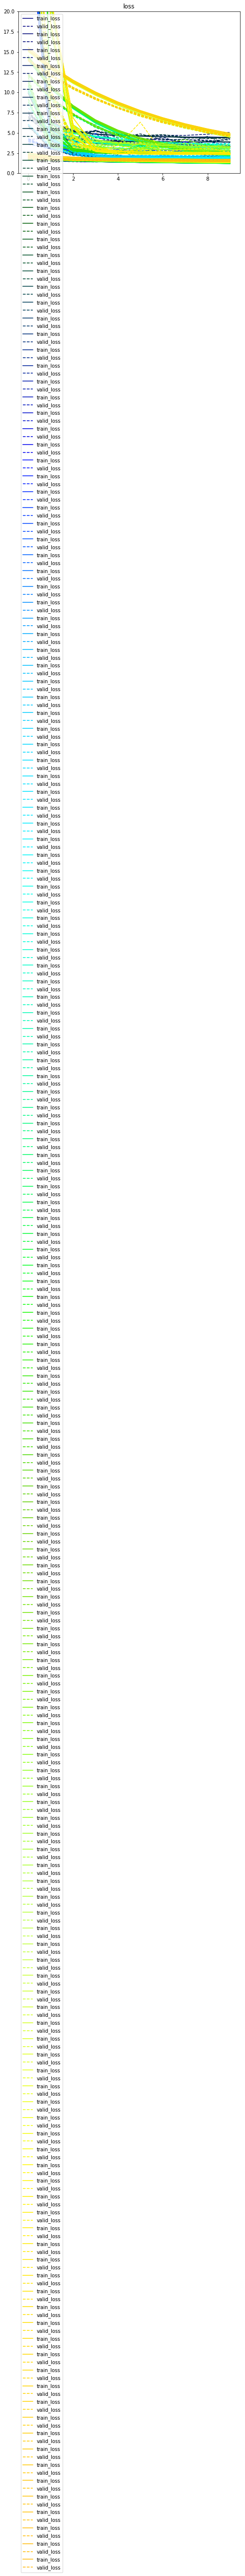

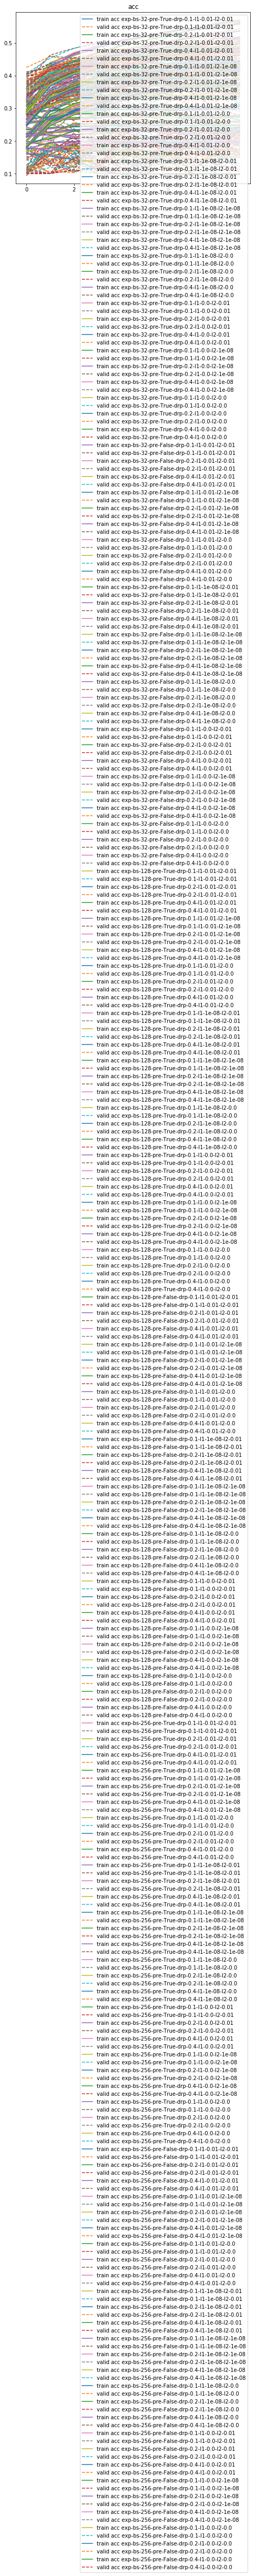

'Code Here\n將結果繪出\n'

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline

color_bar = ['r', 'g', 'b', 'y', 'm', 'k','r', 'g', 'b', 'y', 'm', 'k','r', 'g', 'b', 'y', 'm', 'k','r', 'g', 'b', 'y', 'm', 'k']
cmap = plt.get_cmap('gist_ncar')
colors = [cmap(i) for i in range(len(results)+1)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label='train_loss {}'.format(cond), color=colors[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label='valid_loss {}'.format(cond), color=colors[i])
plt.legend()
plt.ylim([0,20])
plt.title('loss')
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])), results[cond]['train-acc'],'-', label='train acc {}'.format(cond), color=colors[i])
    plt.plot(range(len(results[cond]['valid-acc'])), results[cond]['valid-acc'], '--',label='valid acc {}'.format(cond), color)
plt.legend()
plt.title('acc')
plt.show()

"""Code Here
將結果繪出
"""

In [44]:
cmap = plt.get_cmap('gist_ncar')
colors = [cmap(i) for i in range(len(results))]

In [45]:
colors

[(0.0, 0.0, 0.502, 1.0),
 (0.0, 0.028619761630142255, 0.46510649750096117, 1.0),
 (0.0, 0.05723952326028451, 0.42821299500192234, 1.0),
 (0.0, 0.08585928489042677, 0.3913194925028835, 1.0),
 (0.0, 0.11447904652056902, 0.35442599000384467, 1.0),
 (0.0, 0.14309880815071127, 0.31753248750480584, 1.0),
 (0.0, 0.17171856978085354, 0.280638985005767, 1.0),
 (0.0, 0.2003383314109958, 0.24374548250672812, 1.0),
 (0.0, 0.22895809304113804, 0.20685198000768934, 1.0),
 (0.0, 0.2575778546712803, 0.1699584775086505, 1.0),
 (0.0, 0.28619761630142254, 0.13306497500961167, 1.0),
 (0.0, 0.3148173779315648, 0.09617147251057284, 1.0),
 (0.0, 0.34343713956170707, 0.059277970011533954, 1.0),
 (0.0, 0.3720569011918493, 0.02238446751249512, 1.0),
 (0.0, 0.3457462695096253, 0.0870866880085368, 1.0),
 (0.0, 0.3191596057002035, 0.15229943977591043, 1.0),
 (0.0, 0.29257294189078176, 0.21751219154328405, 1.0),
 (0.0, 0.26598627808136, 0.2827249433106577, 1.0),
 (0.0, 0.23939961427193826, 0.3479376950780313, 1.0),

In [46]:
cmap